In [157]:
import torch
import chess
import chess.svg
import chess.pgn
import numpy as np
from IPython.display import SVG

from models.autoencoder import AE
from models.siamese import Siamese

In [14]:
device = torch.device("cpu")

featurizer = AE().to(device)
comparator = Siamese().to(device)

In [21]:
ae_state_dict = torch.load('checkpoints/best_autoencoder.pth.tar', map_location=lambda storage, loc: storage)
siamese_state_dict = torch.load('checkpoints/best_siamese.pth.tar', map_location=lambda storage, loc: storage)

featurizer.load_state_dict(ae_state_dict['state_dict'])
comparator.load_state_dict(siamese_state_dict['state_dict'])

In [43]:
featurizer.eval()
comparator.eval()

Siamese(
  (fc1): Linear(in_features=200, out_features=400, bias=True)
  (bn1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (bn2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=200, out_features=100, bias=True)
  (bn3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=100, out_features=2, bias=True)
  (bn4): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [22]:
def get_bitboard(board):
    '''
    params
    ------

    board : chess.pgn board object
        board to get state from

    returns
    -------

    bitboard representation of the state of the game
    64 * 6 + 5 dim binary numpy vector
    64 squares, 6 pieces, '1' indicates the piece is at a square
    5 extra dimensions for castling rights queenside/kingside and whose turn

    '''

    bitboard = np.zeros(64*6*2+5)

    piece_idx = {'p': 0, 'n': 1, 'b': 2, 'r': 3, 'q': 4, 'k': 5}

    for i in range(64):
        if board.piece_at(i):
            color = int(board.piece_at(i).color) + 1
            bitboard[(piece_idx[board.piece_at(i).symbol().lower()] + i * 6) * color] = 1

    bitboard[-1] = int(board.turn)
    bitboard[-2] = int(board.has_kingside_castling_rights(True))
    bitboard[-3] = int(board.has_kingside_castling_rights(False))
    bitboard[-4] = int(board.has_queenside_castling_rights(True))
    bitboard[-5] = int(board.has_queenside_castling_rights(False))

    return bitboard

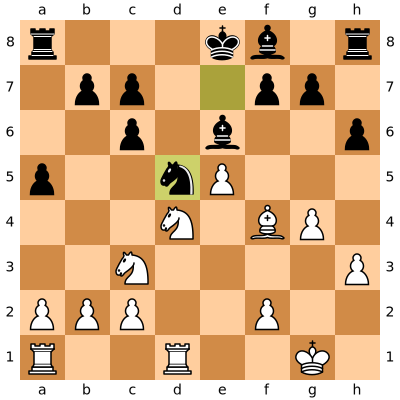

In [179]:
board = chess.Board()
with open('opening.pgn') as f:
    board = chess.pgn.read_game(f)
board = board.end().board()
board

[Move.from_uci('f4h6'), Move.from_uci('f4g5'), Move.from_uci('f4g3'), Move.from_uci('f4e3'), Move.from_uci('f4h2'), Move.from_uci('f4d2'), Move.from_uci('f4c1'), Move.from_uci('d4e6'), Move.from_uci('d4c6'), Move.from_uci('d4f5'), Move.from_uci('d4b5'), Move.from_uci('d4f3'), Move.from_uci('d4b3'), Move.from_uci('d4e2'), Move.from_uci('c3d5'), Move.from_uci('c3b5'), Move.from_uci('c3e4'), Move.from_uci('c3a4'), Move.from_uci('c3e2'), Move.from_uci('c3b1'), Move.from_uci('g1h2'), Move.from_uci('g1g2'), Move.from_uci('g1h1'), Move.from_uci('g1f1'), Move.from_uci('d1d3'), Move.from_uci('d1d2'), Move.from_uci('d1f1'), Move.from_uci('d1e1'), Move.from_uci('d1c1'), Move.from_uci('d1b1'), Move.from_uci('a1c1'), Move.from_uci('a1b1'), Move.from_uci('g4g5'), Move.from_uci('h3h4'), Move.from_uci('f2f3'), Move.from_uci('b2b3'), Move.from_uci('a2a3'), Move.from_uci('b2b4'), Move.from_uci('a2a4')]


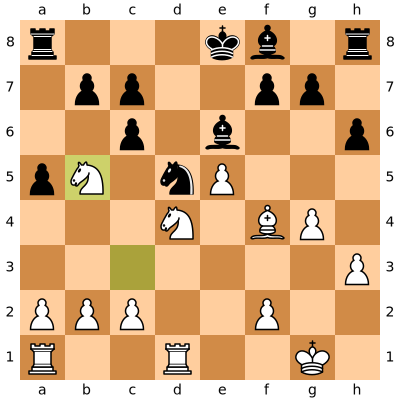

In [177]:
moves = board.generate_legal_moves()
moves = list(moves)
print(moves)
board.push(moves[np.random.randint(len(moves))])
#SVG(chess.svg.board(board=board))
board

In [24]:
def featurize(boards):
    boards = torch.from_numpy(boards).type(torch.FloatTensor)
    return featurizer(boards)

In [25]:
def gen_compare_array(features):
    catcats = []
    for feature in features:
        cats = []
        for compared in features:
            cats.append(np.hstack((feature, compared)))
        cats = np.array(cats)
        catcats.append(cats)
    return np.vstack(catcats)

In [26]:
def compare(features):
    features = torch.from_numpy(features).type(torch.FloatTensor)
    return comparator(features).detach().numpy()

In [173]:
moves = board.generate_legal_moves()
moves = list(moves)

bitboards = []
for move in moves:
    b = board.copy()
    b.push(move)
    bitboards.append(get_bitboard(b))

bitboards = np.array(bitboards)

recon, features = featurize(bitboards)
features = features.detach().numpy()

to_compare = gen_compare_array(features)

to_compare_2 = np.zeros(to_compare.shape)
to_compare_2[:, :100] = to_compare[:, 100:]
to_compare_2[:, 100:] = to_compare[:, :100]

pred = compare(to_compare)
pred = (pred > .5).astype(int)
splits = np.split(pred, len(moves))

pred2 = compare(to_compare_2)
pred2 = 1 - (pred2 > .5).astype(int)
splits2 = np.split(pred2, len(moves))

scores = np.array([np.sum(split[:, 0]) for split in splits])
scores2 = np.array([np.sum(split[:, 0]) for split in splits2])
print(scores)
print(scores2)
print(scores+scores2)
best_idx = np.argmax(scores + scores2)
board.push(moves[best_idx])

board

AttributeError: 'Game' object has no attribute 'generate_legal_moves'

[1.         0.99999976 0.9999999  0.9999999  1.         1.
 1.         0.99999976 0.99999964 1.         1.         0.9999999
 0.9999665  1.         1.         0.99999964 1.         0.9999938
 0.99999976 0.99904317 1.         0.9999943  0.99999976 0.9999975
 0.9998741  0.9999999  0.999803  ]


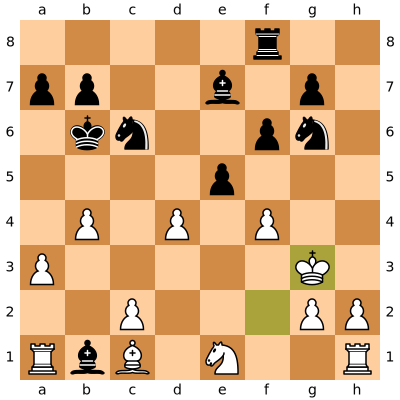

In [129]:
moves = board.generate_legal_moves()
moves = list(moves)

bitboards = []
for move in moves:
    b = board.copy()
    b.push(move)
    bitboards.append(get_bitboard(b))

bitboards = np.array(bitboards)
curr_bitboard = get_bitboard(board)

_, features = featurize(bitboards)
features = features.detach().numpy()

_, curr_features = featurize(curr_bitboard)
curr_features = curr_features.detach().numpy()

to_compare = np.hstack((np.repeat(curr_features, len(moves), axis=0), features))

scores = compare(to_compare)
scores = scores[:, 0]

print(scores)
best_idx = np.argmax(scores)

board.push(moves[best_idx])

board

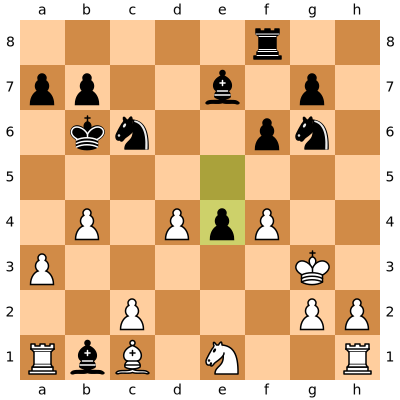

In [131]:
board.push_san('e4')
board

In [184]:
def compare_boards(a,b):
    a, b = get_bitboard(a), get_bitboard(b)
    a, b = featurize(a)[1].detach(), featurize(b)[1].detach()
    to_compare = np.hstack((a,b))
    return compare(to_compare)[0][0]

def minimax(board, depth, white, orig_board):
    if depth == 0:
        return compare_boards(board, orig_board)
    if white:
        best_value = -100 # very (relatively) small number
        moves = board.generate_legal_moves()
        moves = list(moves)
        for move in moves:
            new_board = board.copy()
            new_board.push(move)
            v = minimax(new_board, depth - 1, False, orig_board)
            best_value = max(v, best_value)
        return best_value
    else:
        best_value = 100 # very (relatively) large number
        moves = board.generate_legal_moves()
        moves = list(moves)
        for move in moves:
            new_board = board.copy()
            new_board.push(move)
            v = minimax(new_board, depth - 1, True, orig_board)
            best_value = min(v, best_value)
        return best_value
    
def alphabeta(board, depth, alpha, beta, white, orig_board):
    if depth == 0:
        return compare_boards(board, orig_board), None
    if white:
        v = -100 # very (relatively) small number
        moves = board.generate_legal_moves()
        moves = list(moves)
        best_move = None
        for move in moves:
            new_board = board.copy()
            new_board.push(move)
            candidate_v, _ = alphabeta(new_board, depth - 1, alpha, beta, False, orig_board)
            if candidate_v >= v:
                v = candidate_v
                best_move = move
            else:
                pass
            alpha = max(alpha, v)
            if beta <= alpha:
                break
        return v, best_move
    else:
        v = 100 # very (relatively) large number
        moves = board.generate_legal_moves()
        moves = list(moves)
        best_move = None
        for move in moves:
            new_board = board.copy()
            new_board.push(move)
            candidate_v, _ = alphabeta(new_board, depth - 1, alpha, beta, False, orig_board)
            if candidate_v <= v:
                v = candidate_v
                best_move = move
            else:
                pass
            beta = min(beta, v)
            if beta <= alpha:
                break
        return v, best_move

#minimax(board, 3, True, board)
alphabeta(board, 3, -100, 100, True, board)

(4.5127432e-10, Move.from_uci('d4c6'))